<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="25%"/>
  </p>
  
# **Trabajo Práctico 2: Críticas Cinematográficas**
### **Grupo**: 11 - Los Pandas 🐼
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
- ### 106861 - Labollita, Francisco
- ### 102312 - Mundani Vegega, Ezequiel
- ###  97263 - Otegui, Matías Iñaki

# Modelo XGBoost

Utilizando el dataset modificado, se entrena un modelo de XGBoost y luego se lo optimiza mediante gridsearch.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import warnings
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore', 'is_sparse is deprecated')


In [6]:
reviews = pd.read_csv('train_clean.csv')

## Se entrena un modelo básico de XGBoost

In [7]:
# Se transforma sentimiento de variable categórica a booleana
reviews['sentimiento'] = reviews['sentimiento'].replace({'positivo': 1})
reviews['sentimiento'] = reviews['sentimiento'].replace({'negativo': 0})

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    reviews['review_es'], reviews['sentimiento'], test_size=0.2, random_state=42)

# Se crea una matriz de términos de documento utilizando CountVectorizer
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train)
x_test_counts = vectorizer.transform(x_test)

model = xgb.XGBClassifier(random_state=0, n_jobs=-1)

model.fit(x_train_counts, y_train)
y_test_pred = model.predict(x_test_counts)
print("F1 score: ", f1_score(y_test, y_test_pred))

F1 score:  0.8342266835591075


## Optimización de hiperparámetros mediante GridSearch

In [8]:
model = xgb.XGBClassifier(random_state=0, n_jobs=5)

param_grid = { "max_depth" : [6, 12, 18], 
               "subsample" : [0.6, 0.8, 1], 
               "colsample_bytree" : [0.8, 1], 
               "n_estimators": [50, 100, 200],
               "learning_rate": [0.2, 0.3, 0.4]
             }

scorer_fn = make_scorer(f1_score)

gridcv = GridSearchCV(estimator=model, 
                      param_grid=param_grid, 
                      scoring=scorer_fn, 
                      refit=False, 
                      cv=3,
                      n_jobs=5)

model = gridcv.fit(X = x_train_counts, y = y_train)

print(gridcv.best_params_)

{'colsample_bytree': 1, 'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}


## Análisis del mejor modelo obtenido

In [14]:
model = xgb.XGBClassifier(colsample_bytree=1,
                          learning_rate=0.4,
                          max_depth=6,
                          n_estimators=200, 
                          subsample=1,
                          random_state=0,
                          n_jobs=-1
                         )
model.fit(x_train_counts, y_train)

# Transformar los datos de prueba y hacer predicciones
x_test_counts = vectorizer.transform(x_test)

y_train_pred = model.predict(x_train_counts)
y_test_pred = model.predict(x_test_counts)

Matriz de confusión de los datos de prueba


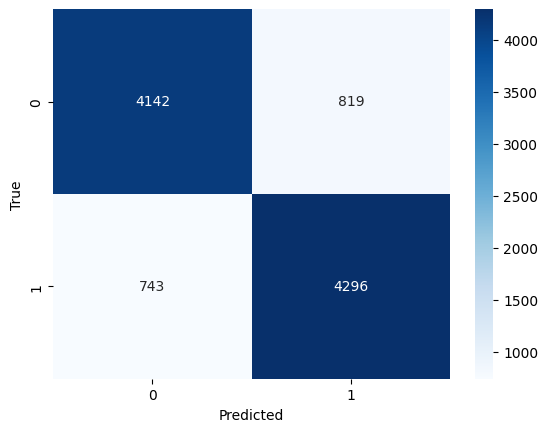

In [15]:
print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [16]:
accuracy=accuracy_score(y_train, y_train_pred)
recall=recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
precision=precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train, y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.946
Recall:  0.956
Precision:  0.937
F1 score:  0.946
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     20039
           1       0.94      0.96      0.95     19961

    accuracy                           0.95     40000
   macro avg       0.95      0.95      0.95     40000
weighted avg       0.95      0.95      0.95     40000



In [17]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test, y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test, y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.844
Recall:  0.853
Precision:  0.84
F1 score:  0.846
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4961
           1       0.84      0.85      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Predicción del conjunto test

In [18]:
test_df = pd.read_csv('test_clean.csv')

#Transformo todas las letras a minúscula
test_df['review_es'] = test_df['review_es'].str.lower()

x_test_counts = vectorizer.transform(test_df['review_es'])
y_pred_test = model.predict(x_test_counts)

test_df['sentimiento'] = y_pred_test
test_df['sentimiento'] = test_df['sentimiento'].apply(lambda x: 'positivo' if x == 1 else 'negativo')

test_df.drop("review_es", axis=1, inplace=True)
test_df.to_csv('sample_solution.csv', index=False)

## Exportación del modelo entrenado

In [ ]:
pickle.dump(model, open("xgboost.pkl", "wb"))